<a href="https://colab.research.google.com/github/wangleiphy/ml4p/blob/main/materials/5_diffprogram/neural_schrodinger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.experimental import ode 

In [ ]:
!nvidia-smi
jax.devices()

Thu Mar 16 03:36:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

# Problem setup 

In quantum optimal control, we integrate time-dependent Schrodinger euqation from $0$ to $T$, under the initial condition $U(0)= I$

$$ \frac{dU}{dt} = -i H (t)U.$$ 

We'd like find an optimal control Hamiltonian so that the final evolution operator $U(T)$ match a desired gate, say,  the CNOT gate. 

Here $$H(t)= h_0 + \sum_{i=1}^{n_{ctrl}} u_i(t) h_i ,$$
where $h_i$'s are time-independent Hamiltonian. For generalirity, let's assume they are just random Hamiltonains (Fill in your favorate ones if you like). 

$u_i(t)$ are control field. We parametrize them as superpositions of Fourier series:

$$u_i(t) = \sum_{j=1}^{n_{basis}} u_{ij} \sin\left(\frac{\pi j t}{T}\right).$$ So, in the end, we try to find out suitiable $u_{ij}$'s to achieve our goal. 



First, set up the target unitary and the Hamiltonian terms

In [ ]:
dim = 1<<2 # Hilbert space dimension
n_ctrl = 4 # number of contorl term
t_final = 1.0 # final control time

U_target = jnp.array([[1, 0, 0, 0], 
                      [0, 1, 0, 0], 
                      [0, 0, 0, 1], 
                      [0, 0, 1, 0]]) #CNOT

key = jax.random.PRNGKey(42)

#drift term
key, *subkeys = jax.random.split(key, 3)
H0 = jax.random.normal(subkeys[0], (dim, dim)) + 1J*jax.random.normal(subkeys[1], (dim, dim)) 
H0 = (H0 + jnp.transpose(jnp.conjugate(H0)))/2

#control term
H_ctrl = []
for i in range(n_ctrl): 
  key, *subkeys = jax.random.split(key, 3)
  H1 = jax.random.normal(subkeys[0], (dim, dim)) + 1J*jax.random.normal(subkeys[1], (dim, dim)) 
  H1 = (H1 + jnp.transpose(jnp.conjugate(H1)))/2
  H_ctrl.append(H1)

Here is our time-dependent Hamiltonian:

In [ ]:
def buildH(t, params):
  H = H0
  params = params.reshape(n_ctrl, n_basis)
  for i, H1 in enumerate(H_ctrl):
    u = jnp.sum(jnp.sin((jnp.arange(n_basis)+1)*jnp.pi*t/t_final) * params[i])
    H = H + H1 * u 
  return H

# Objective function

So, our loss function will be the gate infidelity 

$$\mathcal{L} = 1- \frac{1}{d} |\mathrm{tr} (U(T)^\dagger U_{target})| $$

In [ ]:
def rhs(psi, t, params):
  H = buildH(t, params)
  return -1J*jnp.dot(H, psi)

In [ ]:
def fidelity(U_target, params):
  Ut = ode.odeint(rhs, 
                  jnp.eye(dim)+1J*0, 
                  jnp.array([0.0, t_final]), 
                  params) 

  return jnp.abs(jnp.trace(jnp.transpose(jnp.conjugate(Ut[-1]))@U_target))/dim

In [ ]:
def loss(params):
  return 1.- fidelity(U_target, params)

# Optimization

For training, we can use quasi-Newton (BFGS) optimizer

In [ ]:
#initial parameters
key, subkey = jax.random.split(key)
n_basis = 10
params = jax.random.normal(subkey, (n_ctrl*n_basis, )) *0.01

import jax.scipy.optimize
results = jax.scipy.optimize.minimize(loss, params, method='BFGS')

print (results.success, results.fun, fidelity(U_target, results.x))

True 3.7698282162601515e-08 0.9999999623017178


Whoa, that is almost perfect! 

Let's now plot the control field after optimization

Text(0, 0.5, 'control field')

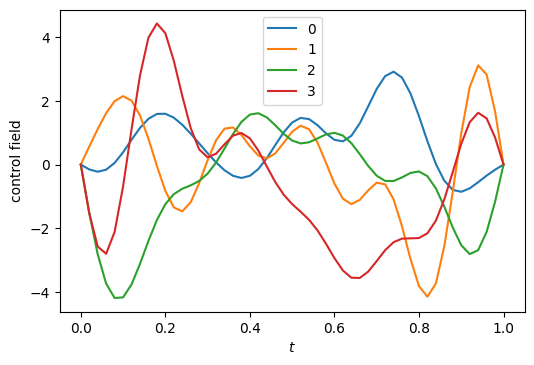

In [ ]:
tlist = jnp.linspace(0, t_final, 51)
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 4), dpi=100)
for i in range(n_ctrl):
  coef_optimized = [jnp.sum(jnp.sin((jnp.arange(n_basis)+1)*jnp.pi*t/t_final) * results.x.reshape(n_ctrl, n_basis)[i] ) for t in tlist]
  plt.plot(tlist, coef_optimized, label='%g'%(i))
plt.legend()
plt.xlabel('$t$')
plt.ylabel('control field')

Let's investigate hessian of the control. This is something you can easily do with `jax`. 

We simply compute seconder order gradient through the whole evolution and plot eigenvalues of the Hesssian matrix. Recall that at optimal we have 

$$ \mathcal{L} = \mathcal{L}(u^\ast) + \frac{1}{2}\frac{\partial ^2 \mathcal{L}}{\partial u_i \partial u_j} du_i du_j $$

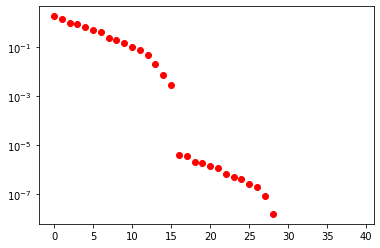

In [ ]:
params = results.x
hess = jax.jacrev(jax.jacrev(loss))(params) # jax.hessian does fwd over rev

w, v = jnp.linalg.eigh(hess)

import matplotlib.pyplot as plt
plt.plot(w[::-1], 'ro')
plt.yscale('log')

Hmmm! Looks like there are only 15 dominant eigenvalues. Those are the relevant directions in the search. 

Related discussions in quantum control
* Quantum optimal control: Hessian analysis of the control landscape, https://aip.scitation.org/doi/10.1063/1.2198836
* Dynamic Dimensionality Identification for Quantum Control, https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.112.143001


Interestingly, there are also similar discussions for overparametrized neural networks:
* Empirical Analysis of the Hessian of Over-Parametrized Neural Networks, https://arxiv.org/abs/1706.04454


This observation can actually be useful when you want to perform "closed-loop" control afterwards.

More things to explore:

* Treating the Schrodinger equation as a general ordinary differential equation may break the unitarity. However, if you wish, you can always restore it by choosing a specialized integrator, see, for example, https://arxiv.org/abs/2001.01013. 

* What do you do if the Hessian matrix is too large to diagonalize ? Note that we only need dominant eigenvalues/states anyway ? HINT: look for `hvp` here https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html. 

* Note that we were using `jacrev` twice to compute the Hessian matrix other than the "forward-over-reverse" mode recommened in the jax [autodiff cookbook](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html). This is because currently jax does not support forward mode AD for neural ODE. You can follow its progress in this issue https://github.com/google/jax/issues/1927. 

* How about adding a noise term in the Hamiltonian ? HINT: try to simulate a batch of noisy evolution with `jax.vmap`

# sandbox

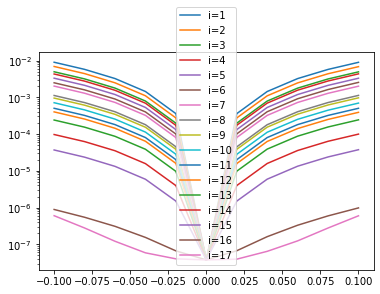

In [ ]:
#pertub the optimal parameter in the principal direction
xlist  = jnp.linspace(-0.1, 0.1, 11)
for i in range(1, 18):
  ylist = []
  for delta in xlist:
    ylist.append(loss(params + delta * v[:, -i]))
  plt.plot(xlist, ylist, label='i=%g'%(i))
plt.legend()
plt.yscale('log')

Or, the L-BFGS implementation from `scipy`

In [ ]:
import numpy as np
from scipy.optimize import minimize
def fun(x):
  f, g = jax.value_and_grad(loss)(x)
  return f, np.array(g)
results = minimize(fun, np.array(params), method='L-BFGS-B', jac=True, options={'gtol': 1e-07})

print (results.success, results.fun, fidelity(U_target, results.x))

True 3.737056253338977e-08 0.9999999626294375


In [ ]:
def hvp(f, x, v):
    return jax.grad(lambda x: jnp.vdot(jax.grad(f)(x), v))(x)
    
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import LinearOperator
nparams = params.shape[0]
hess = LinearOperator((nparams, nparams), matvec=lambda v: hvp(loss, params, v))
%timeit eigenvalues, eigenvectors = eigsh(hess, k=6, which='LM')

7.16 s ± 100 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
